### 1. Caricamento e Preprocessing delle Immagini e delle Maschere ###

In questo codice, carichiamo le immagini e le relative maschere per l'addestramento di un modello di segmentazione.
<br><br> Riscala e Caricamento delle Immagini e delle Maschere <br>
Le immagini e le maschere vengono caricate dalle rispettive cartelle e ridimensionate alle dimensioni desiderate di 128x128 pixel. Questo assicura che tutte le immagini abbiano le stesse dimensioni e siano compatibili con il modello.

<br>Divisione dei Dati<br>
I dati vengono divisi in set di training e di validation utilizzando la funzione `train_test_split` dal modulo `sklearn.model_selection`. In questo caso, il 33% delle immagini verranno utilizzate come set di validation, mentre il restante 67% verrà utilizzato per il training del modello.

<br> Immagini di Test <br>
Alcune immagini sono state rimosse dal dataset e collocate nella cartella "test_data". Queste immagini verranno utilizzate per valutare le prestazioni del modello dopo l'allenamento sul set di training e di validation.



In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3  # RGB

# image and mask for training path 
data_folder = "../training_data"
images_folder = os.path.join(data_folder, "horses")
masks_folder = os.path.join(data_folder, "masks")

train_ids = os.listdir(images_folder)

# array of images and masks
X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

for i, image_name in enumerate(train_ids):
    # read the image
    image_path = os.path.join(images_folder, image_name)
    image = cv2.imread(image_path)
    # scale to desired size
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    # seve the sclaed image 
    X[i] = image
    
    # Read the corresponding mask
    mask_path = os.path.join(masks_folder, image_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # scale to desired size
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    # add 1 dimenction at the mask
    mask = np.expand_dims(mask, axis=-1)
    # save the sclaed mask 
    y[i] = mask

# Now X contain images and y contain the corresponding masks, both scaled 

# splitto per training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)  

### **2. Architettura U-Net** ###
L'rchitettura è basata sulla U-Net, una rete neurale convoluzionale utilizzata per compiti come segmentazione delle immagini. È composta da un encoder e un decoder, con connessioni skip tra i corrispondenti livelli dell'encoder e del decoder per trasferire informazioni dettagliate durante la ricostruzione. La struttura del modello si è basata sulla struttura della U-net presentata nel seguente articolo [link](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8604041) dove viene mostrata la seguente architettura: ..
<br><br>
                                        ---- immagine ----
<br><br>
E' stato mantenuta la struttura della U-Net citatat ma con una riduzione del numero di filtri nei blocchi sia dell'encoder che del decoder per ridurre il costo computazionale durante l'addestramento, poichè il modello mantiene comuqnue la capacità di catturare caratteristiche rilevanti.

**Encoder**<br>
Composto da una serie di blocchi convoluzionali seguiti da operazioni di max pooling. Ogni blocco convoluzionale riduce progressivamente la dimensione dell'immagine e aumenta la profondità delle caratteristiche estratte.<br>
**Decoder**<br>
Utilizza strati convoluzionali trasposti per eseguire l'up-sampling e ripristinare la dimensione originale dell'immagine. Sono state utilizzate operazioni di concatenazione con i corrispondenti strati dell'encoder consentono di incorporare informazioni dettagliate durante la ricostruzione.
<br>
**Motivazioni delle scelte:**<br>



In [6]:
import tensorflow as tf

# Definizione dell'input
inputs = tf.keras.layers.Input(shape=(None, None, 3))

# Funzione per il blocco convoluzionale
def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    conv = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    return conv

# Definizione dell'encoder
def encoder(inputs):
    c1 = conv_block(inputs, 16)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 256)
    return c5, [c1, c2, c3, c4]

# Definizione del decoder
def decoder(inputs, encoder_output):
    c5, skips = encoder_output

    u1 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    concat1 = tf.keras.layers.concatenate([u1, skips[3]], axis=3)
    c6 = conv_block(concat1, 128)

    u2 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    concat2 = tf.keras.layers.concatenate([u2, skips[2]], axis=3)
    c7 = conv_block(concat2, 32)

    u3 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    concat3 = tf.keras.layers.concatenate([u3, skips[1]], axis=3)
    c8 = conv_block(concat3, 32)

    u4 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    concat4 = tf.keras.layers.concatenate([u4, skips[0]], axis=3)
    c9 = conv_block(concat4, 16)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    return outputs

# Chiamata all'encoder
encoder_output = encoder(inputs)

# Chiamata al decoder con input e output dell'encoder
outputs = decoder(inputs, encoder_output)

# Creazione del modello
model = tf.keras.models.Model(inputs, outputs)


In [7]:
# Compila il modello prima di utilizzarlo per l'addestramento
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Definisci i callback
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Addestramento del modello
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=100, callbacks=callbacks)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6953 - loss: 2.1318 - val_accuracy: 0.7587 - val_loss: 0.6208
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7415 - loss: 0.6100 - val_accuracy: 0.7896 - val_loss: 0.5121
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7723 - loss: 0.5369 - val_accuracy: 0.8136 - val_loss: 0.4510
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7796 - loss: 0.4882 - val_accuracy: 0.8160 - val_loss: 0.4318
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7958 - loss: 0.4580 - val_accuracy: 0.7980 - val_loss: 0.4379
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7840 - loss: 0.4694 - val_accuracy: 0.7808 - val_loss: 0.6961
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7916 - loss: 0.5077 - val_accuracy: 0.8311 - val_loss: 0.3920
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8250 - loss: 0.4028 - val_accuracy: 0.8531 - v

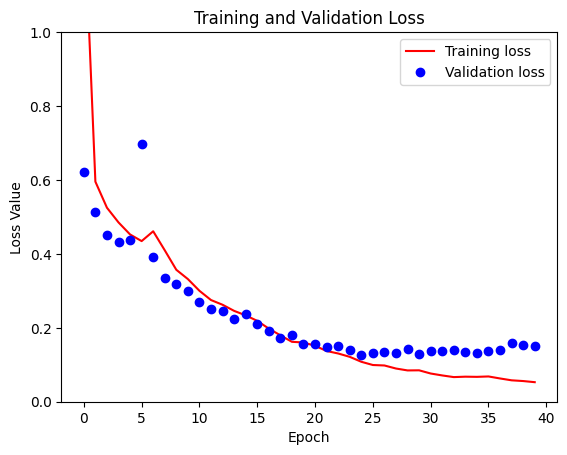

In [8]:
import matplotlib.pyplot as plt
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


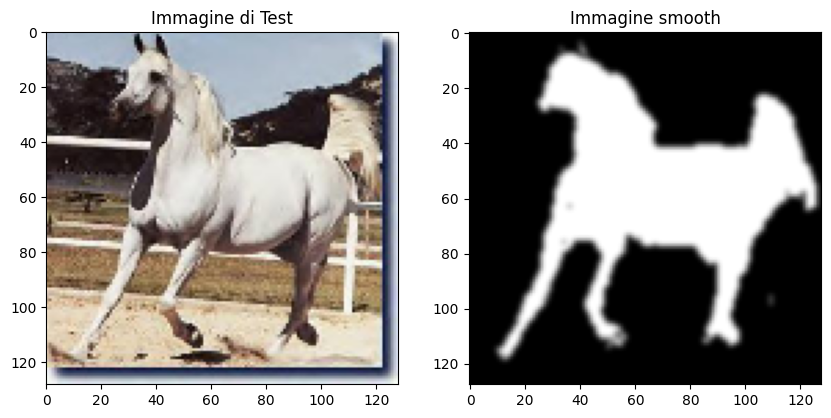

In [9]:
from ctypes import resize
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

IMG_HEIGHT = 128
IMG_WIDTH = 128

#   DA TENERE 050 - 045 - 037 - 267 - 041 (pos) 
# Carica l'immagine di test
test_image_path = "../training_data/horses/horse273.png" # 218 283 315 273
test_image = np.array(Image.open(test_image_path)) 
# Ridimensiona l'immagine di test alle dimensioni desiderate
rescaled_test_image = cv2.resize(test_image, (IMG_HEIGHT, IMG_WIDTH))

# Fai una predizione sull'immagine di test
predicted_mask = model.predict(np.expand_dims(rescaled_test_image, axis=0))[0]
# Soglia per la maschera predetta
threshold = 0.5  # Puoi regolare questa soglia secondo le tue esigenze
# Applica la soglia alla maschera predetta
binary_mask = predicted_mask > threshold

# Visualizza l'immagine di test
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rescaled_test_image, extent=[0, IMG_WIDTH, IMG_HEIGHT, 0])
plt.title('Immagine di Test')


# Visualizza la maschera predetta
# Applica un filtro Gaussiano per rendere l'immagine più smooth
smoothed_mask = cv2.GaussianBlur(binary_mask.astype(float), (5, 5), 0)
# Plot dell'immagine originale e dell'immagine smooth
plt.subplot(1, 2, 2)
plt.imshow(smoothed_mask, cmap='gray')
plt.title('Immagine smooth')
plt.show()


### **X. Test con altri modelli** ###
X.1 FNC 
Come primo modello ho deciso 